In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Input, Reshape, Lambda, Dropout, Flatten 
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization, SeparableConv2D, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
# K.set_image_data_format('channels_first')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
with open('X_test.pkl', 'rb') as file:
    X_test =pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test =pickle.load(file)

In [3]:
y_test = tf.one_hot(y_test, 2)
X_test=X_test.reshape(624,3,150,150)

# CNN

In [4]:
K.set_image_data_format('channels_first')
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 37, 37)        1

In [5]:
model.load_weights('weights1.hdf5')

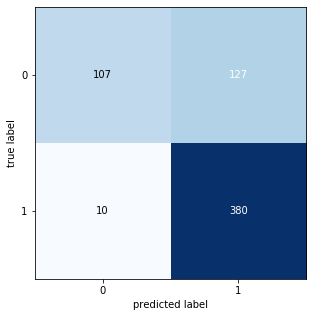

In [6]:
pred_CNN = model.predict(X_test)
pred1_CNN = np.argmax(pred_CNN,axis = 1) 
y_test_CNN = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test_CNN, pred1_CNN)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [7]:
print(classification_report(y_test_CNN, pred1_CNN))

              precision    recall  f1-score   support

           0       0.91      0.46      0.61       234
           1       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



In [8]:
base_model = InceptionV3(include_top=False , input_shape=(3,150,150))
x = base_model.output
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
t_model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
t_model.load_weights('transferlearning_weights2.hdf5')

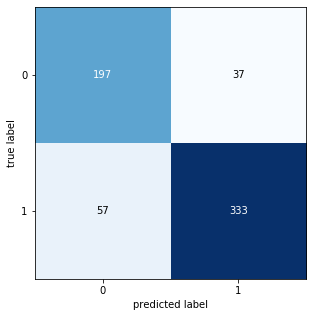

In [10]:
pred_V3 = t_model.predict(X_test)
pred1_V3 = np.argmax(pred_V3,axis = 1) 
y_test_V3 = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test_V3, pred1_V3)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [11]:
print(classification_report(y_test_V3, pred1_V3))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       234
           1       0.90      0.85      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.85      0.85      0.85       624



In [12]:
def ROC (prediction ,test, trueclass, falseclass):
    TP=0
    FN=0
    FP=0
    TN=0
    for i in range (test.shape[0]):
        if prediction[i]==trueclass and test[i]==trueclass:
            TP +=1
        elif prediction[i]==falseclass and test[i]==falseclass:
            TN +=1
        elif prediction[i]==trueclass and test[i]==falseclass:
            FP +=1
        elif prediction[i]==falseclass and test[i]==trueclass:
            FN +=1
#     if TP+FP==0:
#         return TP/(TP+FN), 0
    return  FP/(FP+TN), TP/(TP+FN)

In [53]:
import copy
def process(p,test):
    x=[]
    y=[]
    p = p.tolist()
    p.sort(reverse = False)
    for i in np.arange(0,1.03,0.03):
        predict=[]
        for j in p:
            if j>i:
                predict.append(1)
            else:
                predict.append(0)
        r1, r2 = ROC(predict, test, 1, 0)
        x.append(r1)
        y.append(r2)
    return x,y

In [54]:
x1,y1 = process(pred_V3[:,1],y_test_V3)
x2,y2 = process(pred_CNN[:,1],y_test_CNN)


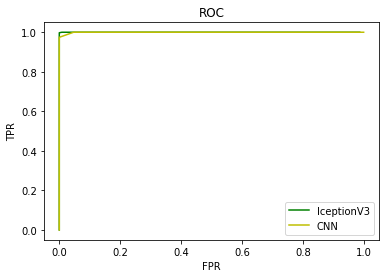

In [58]:
plt.plot(x1,y1,c='g',label='IceptionV3')
plt.plot(x2,y2,c='y',label='CNN')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)